# LendingClub Case Study

Working for a leading online loan marketplace, the objective is to comprehend and mitigate credit loss. Solving this through Exploratory Data Analysis seeks to identify key variables indicating loan default, contributing to portfolio management and risk assessment.

In this EDA, we'll analyze how consumer and loan attributes impact default tendencies, considering dual risks for the bank:
1. Denying a loan to a likely repayer results in business loss.
2. Approving a loan to a potential defaulter poses a financial risk for the company.

In [112]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import re
from datetime import datetime
from natsort import natsorted

## 1. Loading Data

In [87]:
df = pd.read_csv('loan.csv')
# df = pd.read_csv('loan.csv', usecols=['annual_inc_joint'])

# print(df.head())
print(df.shape)

(39717, 111)


C:\Users\KASH\AppData\Local\Temp\ipykernel_2836\3852034578.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('loan.csv')


> The provided dataset comprises 39,717 rows distributed over 111 columns. Notably, one of the columns denotes the current status of the loans, which can be categorized as follows:

> - Current - Loan repayment is on-going.
> - Fully Paid - Loan entirely repaid by the consumer.
> - Charged Off - Loan that has defaulted.

## 2. Cleaning Data

#### a. Dropping columns based on analysis

After analyzing the data, excluding columns which lacks meaningful patterns.
- Unique Identifier columns : id, member_id, url
- Null columns : 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit'
- Constant columns : 'pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'


In [88]:
## Not using this as it is deleting non-null columns as well
# df.dropna(axis=1, inplace=True)

df_row_count = df.shape[0]
uniq_count_col = df.nunique()
df.drop(df.columns[(uniq_count_col == df_row_count) | (uniq_count_col <= 1)], axis=1, inplace=True)

print(df.shape)

(39717, 45)


On further understanding of risk analytics, few other columns were discovered which didn't add any value to our analysis.

- Similar/Subset Columns : grade (as sub_grade includes grade information as well)
- Descriptive Text Columns : desc, title
- Employee Title, Zip Code, Address : emp_title, zip_code, addr_state
- Post Loan Approval Data : last_credit_pull_d, last_pymnt_amnt, last_pymnt_d, total_rec_late_fee, total_rec_prncp, total_rec_int, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, next_pymnt_d, inq_last_6mths, delinq_2yrs
- Post Charge-off Data : recoveries, collection_recovery_fee

In [89]:
df.drop(columns=['grade', 'desc', 'title', 'emp_title', 'zip_code', 'addr_state', 'next_pymnt_d', 'last_credit_pull_d', 
                 'last_pymnt_amnt', 'last_pymnt_d', 'total_rec_late_fee', 'recoveries',
                 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_int', 'out_prncp', 'out_prncp_inv', 
                 'total_pymnt', 'total_pymnt_inv', 'next_pymnt_d', 'inq_last_6mths', 'delinq_2yrs'], inplace=True)

print(df.shape)

(39717, 24)


#### b. Deleting rows based on analysis

In the dataset, loan_status tells us if the loan is paid-off, defaulted or currently in-progress. Since we're not predicting the future status of an on-going loan, it seems wise to exclude it from our analysis.

In [90]:
df.drop(df[df['loan_status'] == 'Current'].index, inplace=True)

print(df.shape)

(38577, 24)


#### c. Dropping columns having more than 60% null values

<Axes: >

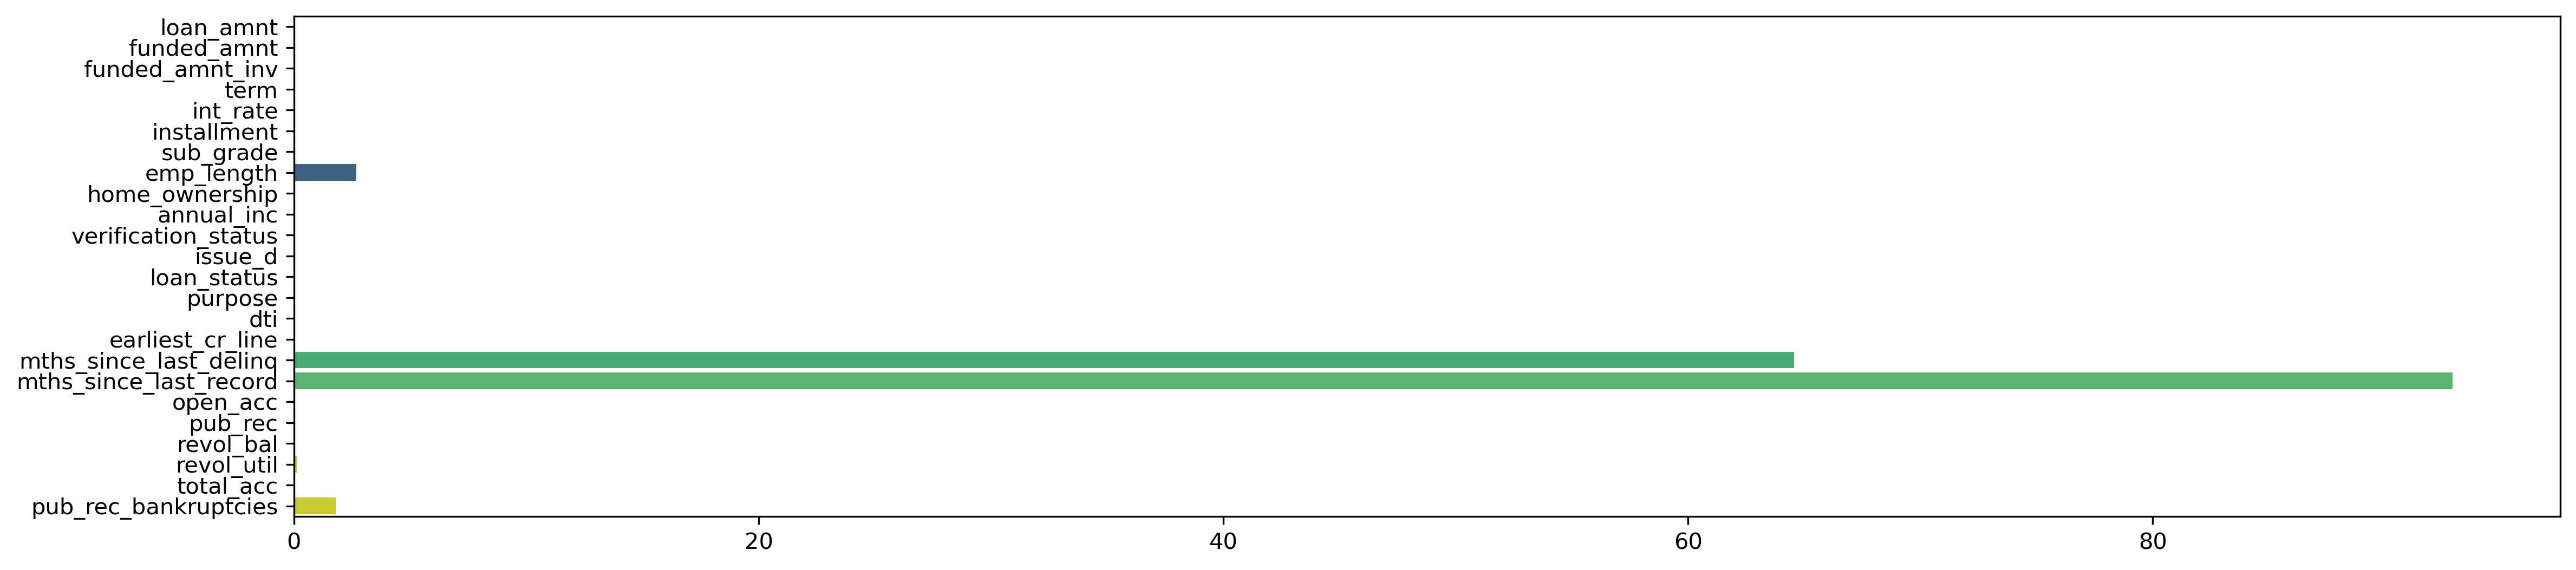

In [91]:
plt.figure(figsize=(18,4),dpi=300)
x_null_val_prcnt = ((df.isnull().sum()/len(df))*100)
y_index = x_null_val_prcnt.index
sns.barplot(y=y_index, x=x_null_val_prcnt, palette='viridis')

> Dropping 'mths_since_last_delinq' and 'mths_since_last_record' columns based on the above Bar plot.

In [92]:
df.drop(columns=['mths_since_last_delinq', 'mths_since_last_record'], inplace=True)

print(df.shape)

(38577, 22)


#### d. Handling Null Values

In [93]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 38577 entries, 0 to 39716
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             38577 non-null  int64  
 1   funded_amnt           38577 non-null  int64  
 2   funded_amnt_inv       38577 non-null  float64
 3   term                  38577 non-null  object 
 4   int_rate              38577 non-null  object 
 5   installment           38577 non-null  float64
 6   sub_grade             38577 non-null  object 
 7   emp_length            37544 non-null  object 
 8   home_ownership        38577 non-null  object 
 9   annual_inc            38577 non-null  float64
 10  verification_status   38577 non-null  object 
 11  issue_d               38577 non-null  object 
 12  loan_status           38577 non-null  object 
 13  purpose               38577 non-null  object 
 14  dti                   38577 non-null  float64
 15  earliest_cr_line      38

> 'emp_length', 'pub_rec_bankruptcies' & 'revol_util' null values can be handled wisely for analysis.

> 'pub_rec_bankruptcies' provides the number of bankruptcies that has been filed for the borrower as per public records. Ideally higher chance of loan approval stands for the borrower who has no such past records i.e., the number is 0.
Mode of the 'pub_rec_bankruptcies' should prove this point.
> For our analysis, we can consider that there is no bankruptcies filed, and hence filling the null values with 0.

In [94]:
print(df['pub_rec_bankruptcies'].mode())

df['pub_rec_bankruptcies'].fillna(0, inplace=True)

0    0.0
Name: pub_rec_bankruptcies, dtype: float64


> 'emp_length' indicates the borrower's years of employment which contains categorical data.

> We cannot handle the null values just by filling it with mean/median/mode values as it can exaggerate the dataset and wrongfully impact our analysis

In [95]:
df['emp_length'].value_counts()

emp_length
10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: count, dtype: int64

> 'revol_util' signifies the percentage of revolving credit that a borrower is utilizing for the loan.
Analyzed dataset and found that Revolving Credit Utilization is null where Revolving Credit Balance is 0. So we can fill the null values with 0% 

In [96]:
df['revol_util'].fillna('0%', inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 38577 entries, 0 to 39716
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             38577 non-null  int64  
 1   funded_amnt           38577 non-null  int64  
 2   funded_amnt_inv       38577 non-null  float64
 3   term                  38577 non-null  object 
 4   int_rate              38577 non-null  object 
 5   installment           38577 non-null  float64
 6   sub_grade             38577 non-null  object 
 7   emp_length            37544 non-null  object 
 8   home_ownership        38577 non-null  object 
 9   annual_inc            38577 non-null  float64
 10  verification_status   38577 non-null  object 
 11  issue_d               38577 non-null  object 
 12  loan_status           38577 non-null  object 
 13  purpose               38577 non-null  object 
 14  dti                   38577 non-null  float64
 15  earliest_cr_line      38

#### e. Handling Data Types

In [97]:
# 'int_rate' and 'revol_util' : Removing '%' and changing data type as float

df['int_rate'] = df['int_rate'].str.replace('%', '').astype(float)
df['revol_util'] = df['revol_util'].str.replace('%', '').astype(float)

#### f. Handling Outliers

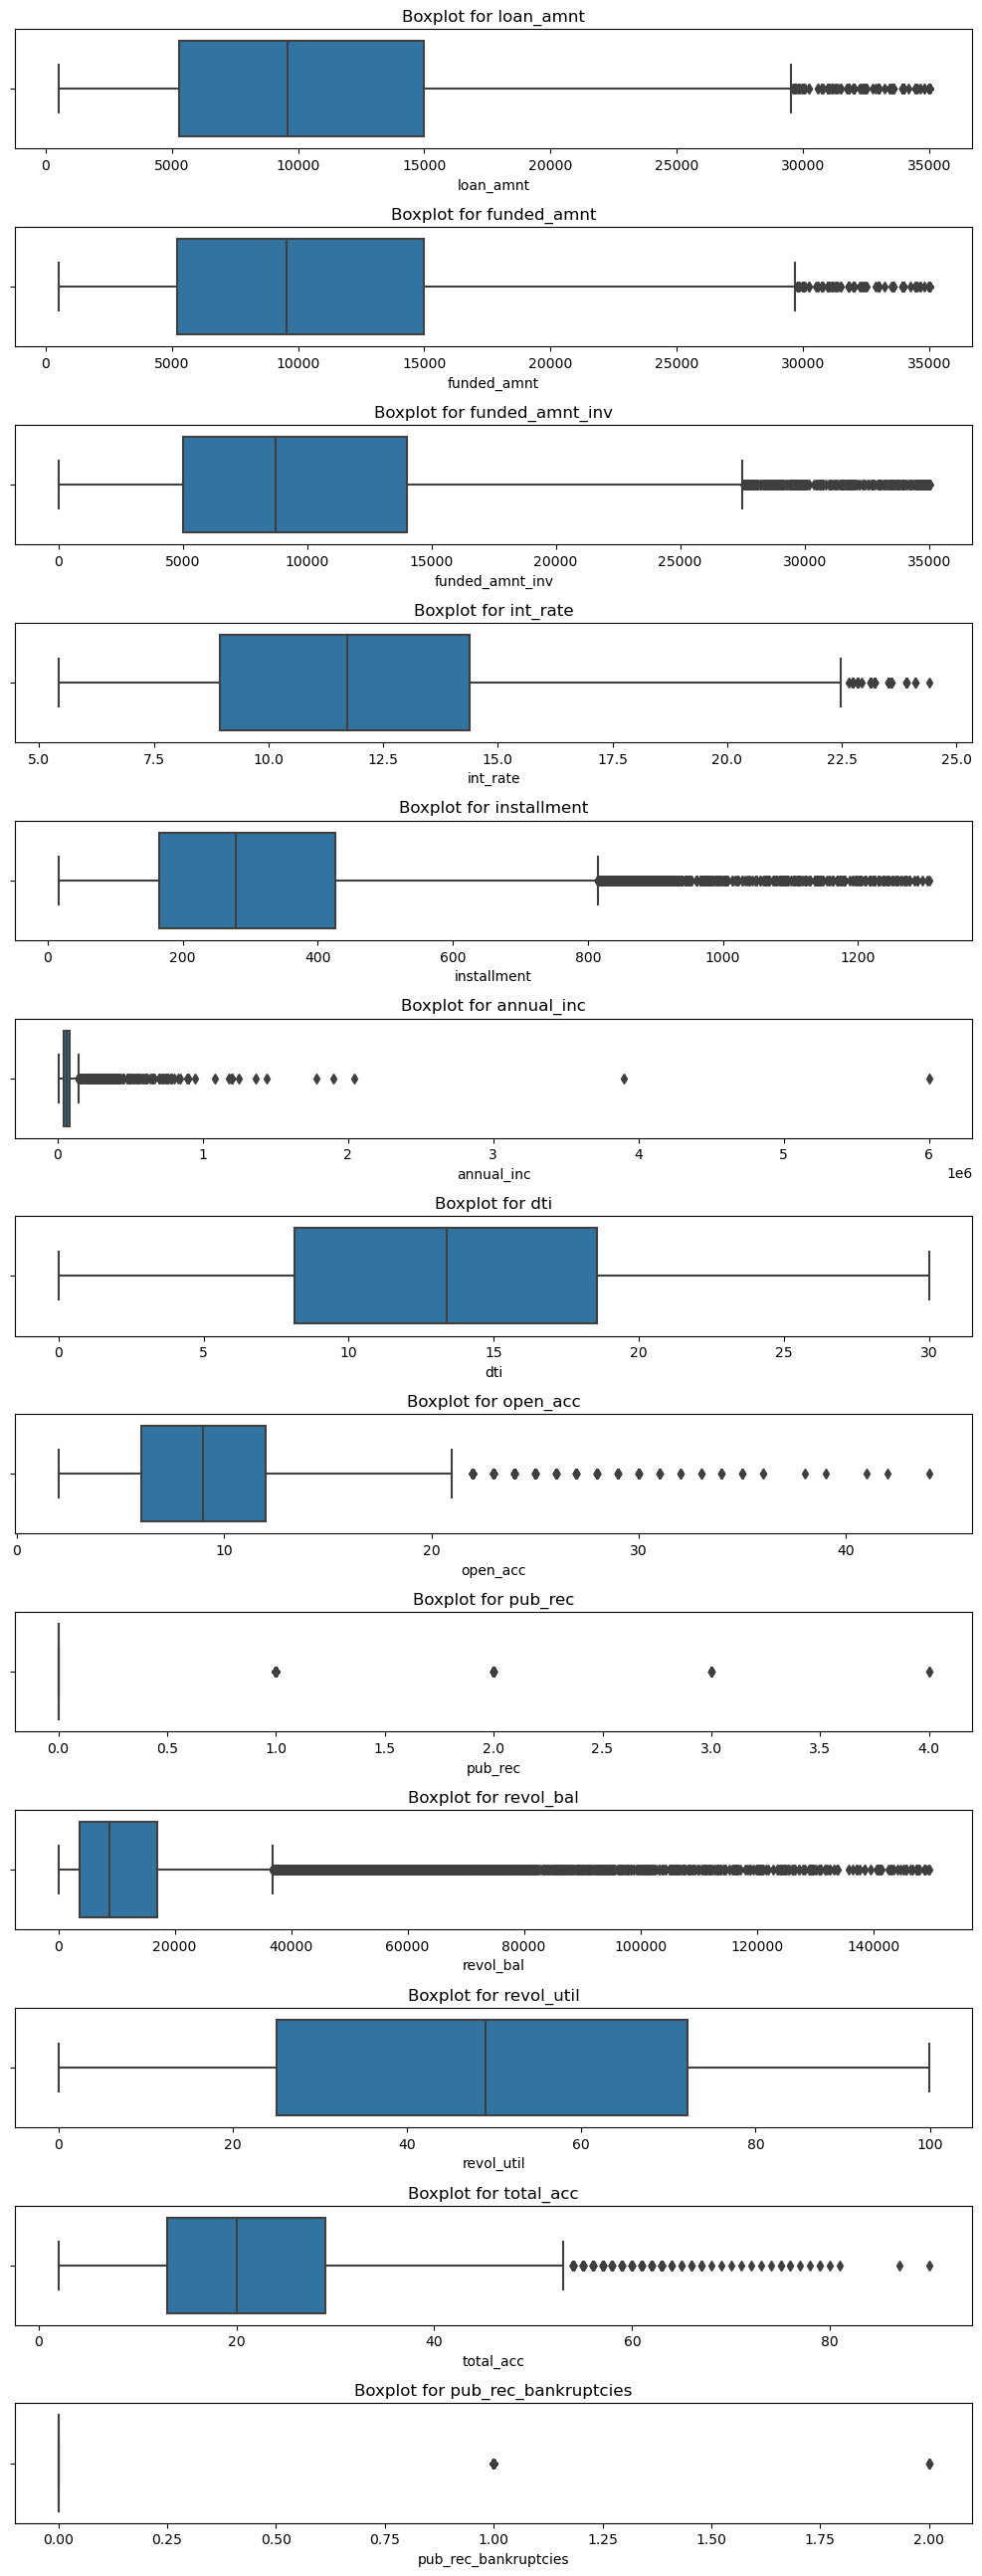

In [98]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Set the figure size based on the number of numerical columns
plt.figure(figsize=(10, 2 * len(numerical_columns)))

# Iterate through each numerical column and create a boxplot
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot for {column}')

plt.tight_layout()
plt.show()

> Observing the Boxplots, Annual Income outliers are very significant and thus should not be considered for our analysis.

(36815, 22)


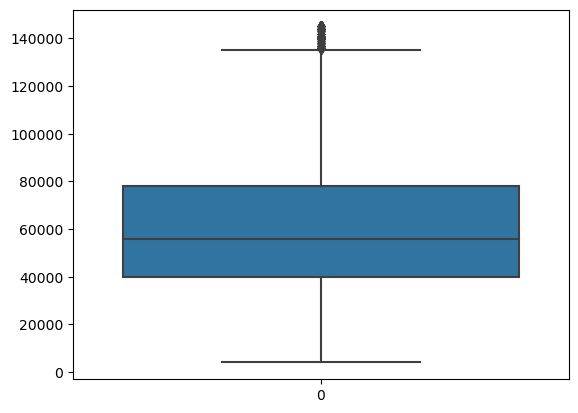

In [99]:
annual_inc_25, annual_inc_75 = df['annual_inc'].quantile([0.25, 0.75])
annual_inc_upper_limit = annual_inc_75 + 1.5 * (annual_inc_75 - annual_inc_25)
df.drop(df[df['annual_inc'] > annual_inc_upper_limit].index, inplace=True)

sns.boxplot(data=df['annual_inc'])

print(df.shape)

From the cleaned dataset, we can categorize the attributes under the following
- Unordered Categorical Variables : purpose
- Ordrered Categorical Variables : term, int_rate, sub_grade, emp_length, home_ownership, verification_status, open_acc, total_acc, pub_rec, revol_util, pub_rec_bankruptcies, loan_status
- Continuous Variables : loan_amnt, funded_amnt, funded_amnt_inv, installment, annual_inc, earliest_cr_line, issue_d, dti, revol_bal

## 3. Feature Engineering

#### a. Handling Categorical Variables

> Loan term can be converted to Integer

In [100]:
df['term'] = df['term'].str.replace(' months', '').astype(int)
print(df['term'].unique())

[36 60]


> Interest rate can be rounded off to nearest integer.

In [101]:
df['int_rate'] = df['int_rate'].round()
print(df['int_rate'].unique())

[11. 15. 16. 13.  8. 19. 21. 10.  6. 12. 14. 17.  9. 18.  7. 20. 22. 24.
 23.  5.]


> Employment experience can be converted to Integer

In [102]:
df['emp_length'] = pd.to_numeric(df['emp_length'].str.replace(r'[^0-9]+', '', regex=True), errors='coerce')
print(df['emp_length'].unique())

[10.  1.  3.  8.  9.  4.  5.  6.  2.  7. nan]


#### b. Handling Time Series Data

> Dates can be converted to 'yyyymm' format for ease of analysis

In [103]:
def date_to_yyyymm(date: str):
    # df[column+'_formatted'] = pd.to_datetime(df[column], errors='coerce').dt.strftime('%Y%m')
    month = datetime.strptime(''.join(re.findall(r'[a-zA-Z]', date)), '%b').strftime('%m')
    if len(month) == 1:
        month = '0' + month
    year = int(''.join(re.findall(r'\d', date)))
    if year <= 24: # Current year is 2024 so it cannot go beyond 2024.
        year = 2000 + year
    else:
        year = 1900 + year
    return int(str(year) + month)

In [104]:
df['earliest_cr_line'] = df['earliest_cr_line'].apply(date_to_yyyymm)
df['issue_d'] = df['issue_d'].apply(date_to_yyyymm)
print(df['earliest_cr_line'].unique())
print(df['issue_d'].unique())

[198501 199904 200111 199602 200411 200507 200701 200404 200409 199801
 198910 200307 199105 200709 199810 199308 200310 200101 199711 198302
 198507 200304 200106 200202 198408 200611 198712 198111 200504 200710
 200012 200704 200301 199403 199809 200406 199511 199907 199506 199209
 200201 199204 200610 200005 199812 200412 200010 200205 200605 200207
 200607 199705 200510 199504 200210 200001 200004 199412 200509 198412
 199912 200311 198906 199610 200305 200206 200706 199612 200209 198601
 199805 199701 200506 199002 200403 199507 199408 199206 199703 200604
 199004 200306 199908 200009 200102 198812 199902 199112 200008 200410
 200408 200502 200511 200011 200705 199101 200006 200608 200212 199306
 200606 200402 199012 200003 199502 200107 200204 200112 200609 199905
 199808 200512 200405 200110 198306 198603 198004 200807 199605 200401
 200211 200208 200108 199103 198909 199409 200309 199909 200508 198612
 199811 200602 199405 200711 199302 199111 200505 199003 199603 197910
 19810

#### c. Binning

Binning in one line can be advantageous for simplicity and conciseness, especially when working with numerical data.

> Borrower's Monthly debt ratio ranges between 0 - 30, and can be binned for intervals of 5

In [105]:
bins = range(0, 31, 5)
labels = range(5, 31, 5)
df['dti'] = pd.cut(df['dti'], bins=bins, labels=labels, include_lowest=True)
df['dti'].astype('int')

0        30
1         5
2        10
3        20
5        15
         ..
39711    20
39712    15
39713    10
39714     5
39716    15
Name: dti, Length: 36815, dtype: int32

> Revolving Credit Utilization rate can range between 0% - 100%, and can be binned for intervals of 10 

In [106]:
bins = range(0, 101, 10)
labels = range(10, 101, 10)
df['revol_util'] = pd.cut(df['revol_util'], bins=bins, labels=labels, include_lowest=True)
df['revol_util'].astype('int')

0         90
1         10
2        100
3         30
5         30
        ... 
39711     30
39712     20
39713     30
39714     20
39716     60
Name: revol_util, Length: 36815, dtype: int32

#### d. Feature Creation

> Earliest Credit Line since the issue date can give some good insights which we will later analyze.

In [107]:
df['years_since_earliest_cr_line'] = (df['issue_d'] - df['earliest_cr_line']) / 100
print(df['years_since_earliest_cr_line'])

# drop issue_d and earliest_cr_line
df.drop(['issue_d', 'earliest_cr_line'], axis=1, inplace=True)

0        26.11
1        12.08
2        10.01
3        15.10
5         7.01
         ...  
39711    13.02
39712    16.96
39713    20.95
39714     8.97
39716     3.96
Name: years_since_earliest_cr_line, Length: 36815, dtype: float64


> Increase in Credit Lines can give some good insights which we will later analyze.

In [108]:
df['increase_in_credit_lines'] = df['total_acc'] - df['open_acc']
print(df['increase_in_credit_lines'])

# drop open_acc and total_acc
df.drop(['open_acc', 'total_acc'], axis=1, inplace=True)

0         6
1         1
2         8
3        27
5         3
         ..
39711    19
39712    27
39713     3
39714     9
39716     1
Name: increase_in_credit_lines, Length: 36815, dtype: int64


Now we can proceed with our analysis with below attributes

- Unordered Categorical Variables : purpose
- Ordrered Categorical Variables : term, int_rate, sub_grade, emp_length, home_ownership, verification_status, increase_in_credit_lines, pub_rec, revol_util, pub_rec_bankruptcies, loan_status
- Continuous Variables : loan_amnt, funded_amnt, funded_amnt_inv, installment, annual_inc, years_since_earliest_cr_line, dti, revol_bal

## 4. Univariate Analysis

In [109]:
df_fully_paid = df[df['loan_status'] == 'Fully Paid']
df_charged_off = df[df['loan_status'] == 'Charged Off']

 #### a. Plotting Correlation with loan_status for Continuous Variables

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'annual_inc'),
  Text(1, 0, 'increase_in_credit_lines'),
  Text(2, 0, 'years_since_earliest_cr_line'),
  Text(3, 0, 'revol_bal'),
  Text(4, 0, 'emp_length'),
  Text(5, 0, 'installment'),
  Text(6, 0, 'dti'),
  Text(7, 0, 'funded_amnt_inv'),
  Text(8, 0, 'pub_rec_bankruptcies'),
  Text(9, 0, 'pub_rec'),
  Text(10, 0, 'funded_amnt'),
  Text(11, 0, 'loan_amnt'),
  Text(12, 0, 'revol_util'),
  Text(13, 0, 'term'),
  Text(14, 0, 'int_rate')])

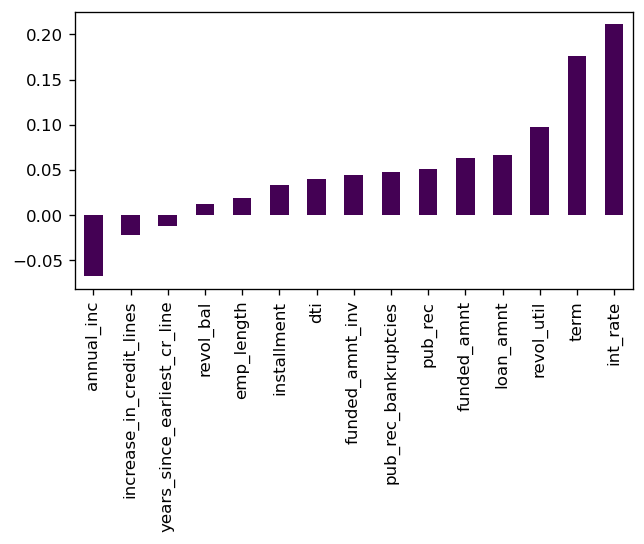

In [110]:
df_temp = pd.concat([df, pd.get_dummies(df['loan_status'])], axis=1)
df_temp.drop(['loan_status', 'sub_grade', 'home_ownership', 'verification_status', 'purpose'], axis=1, inplace=True)

plt.figure(figsize=(6,3),dpi=120)
df_temp.corr()['Charged Off'].sort_values().drop(['Fully Paid', 'Charged Off']).plot(kind='bar', cmap='viridis')
plt.xticks(rotation=90)

**Insights**
> **From the above plot we can clearly observe that 'Interest Rate' is directly proportional to the Defaulted i.e., if the Interest Rate is higher, borrower is more prone to Defaulting.**

#### b. Plotting Correlation with loan_status for Categorical Variables

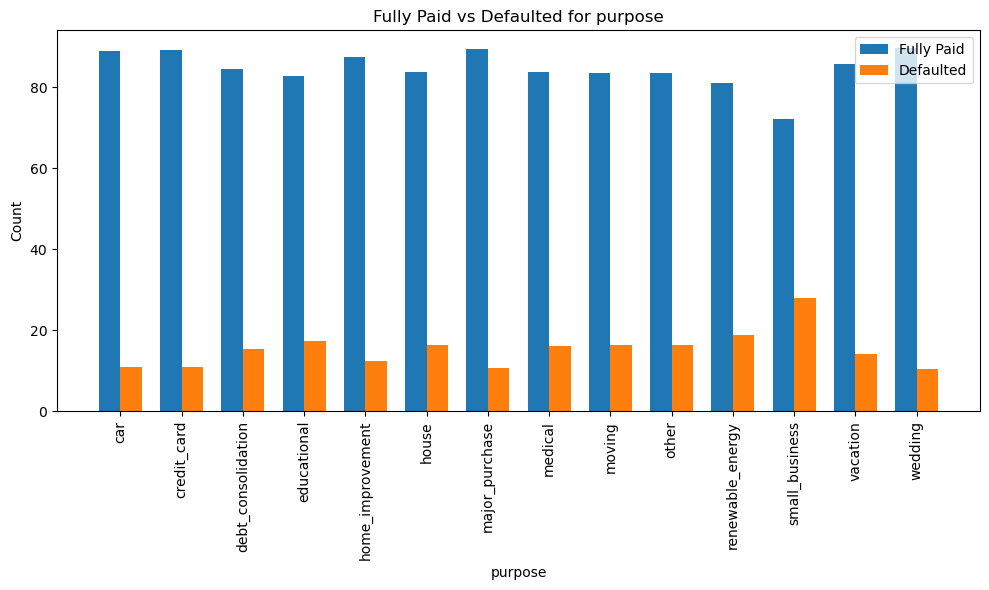

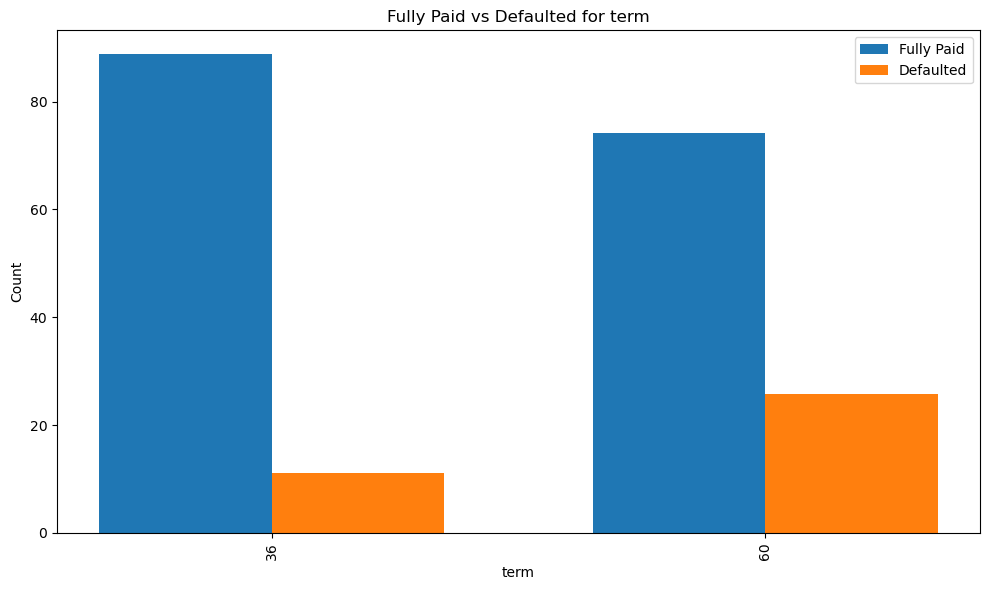

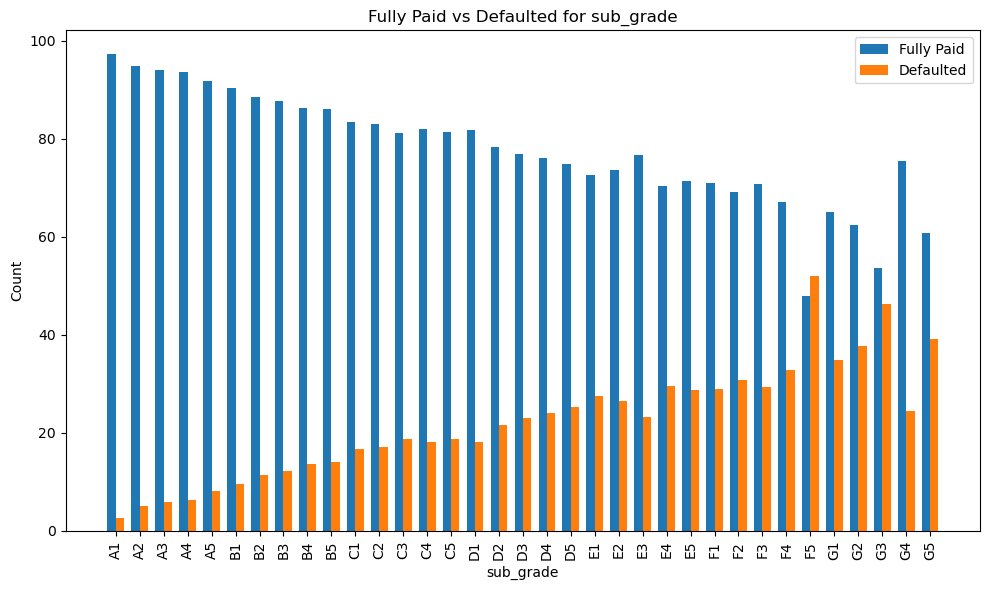

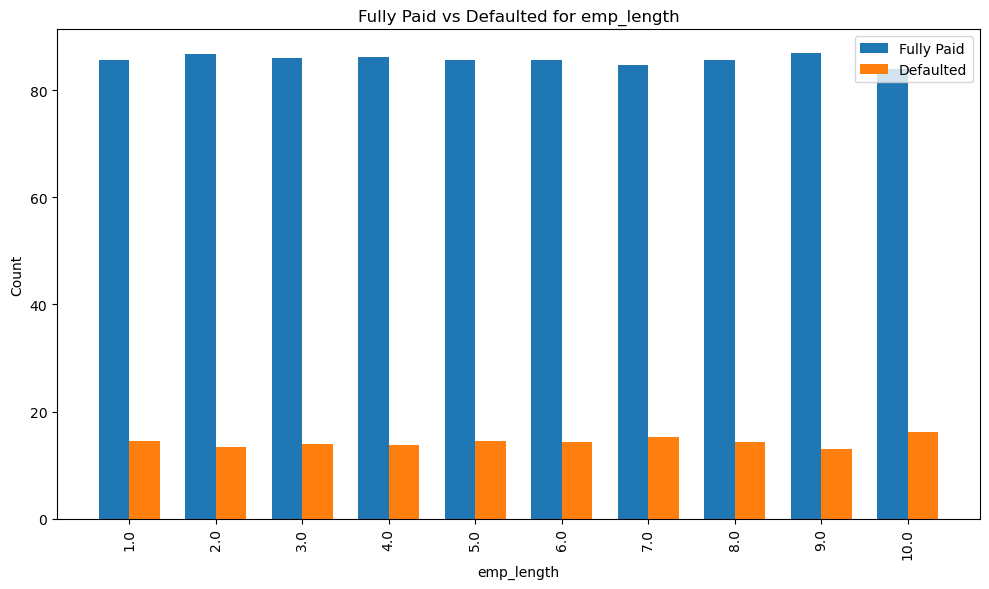

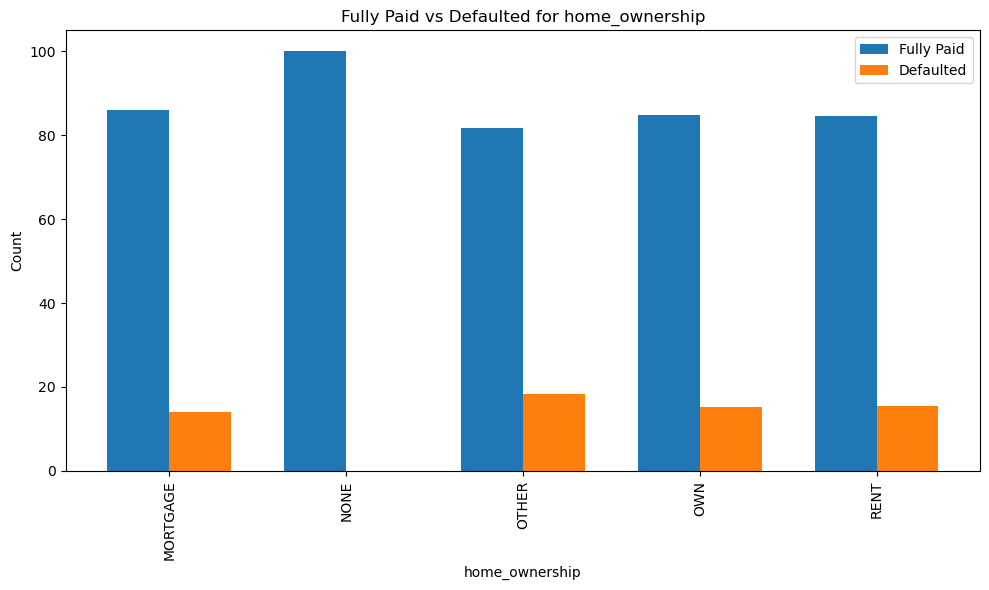

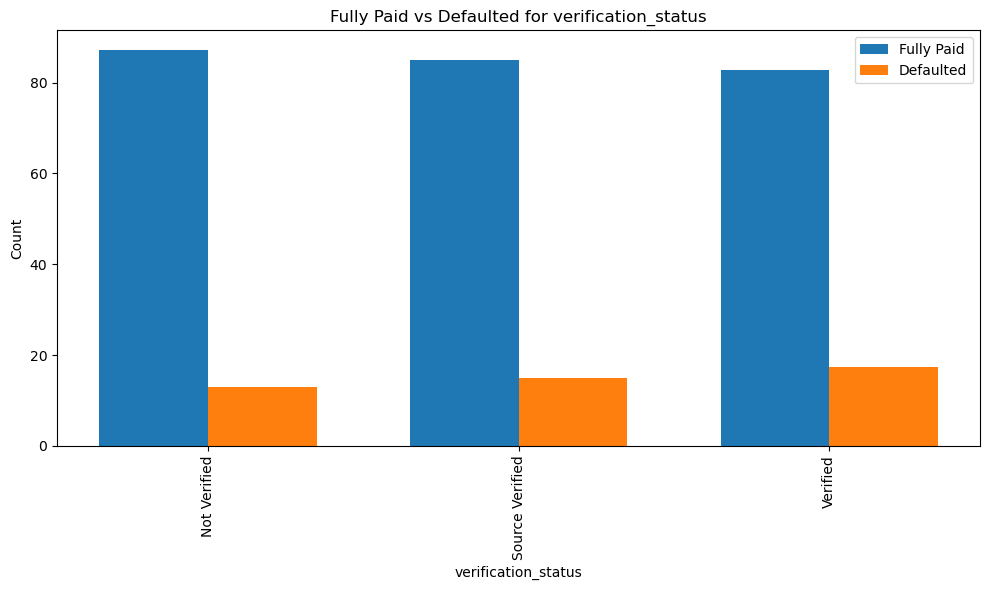

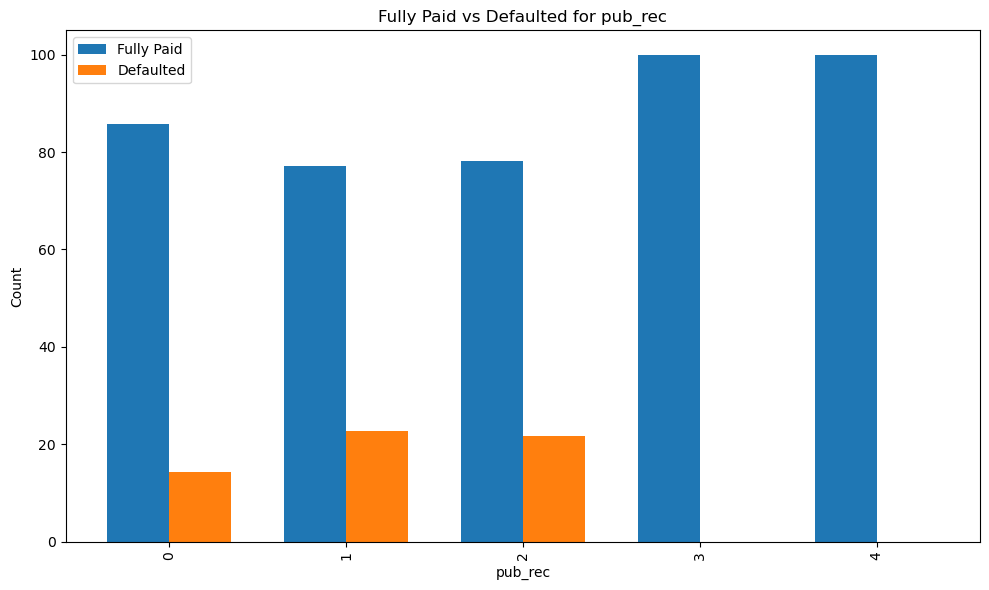

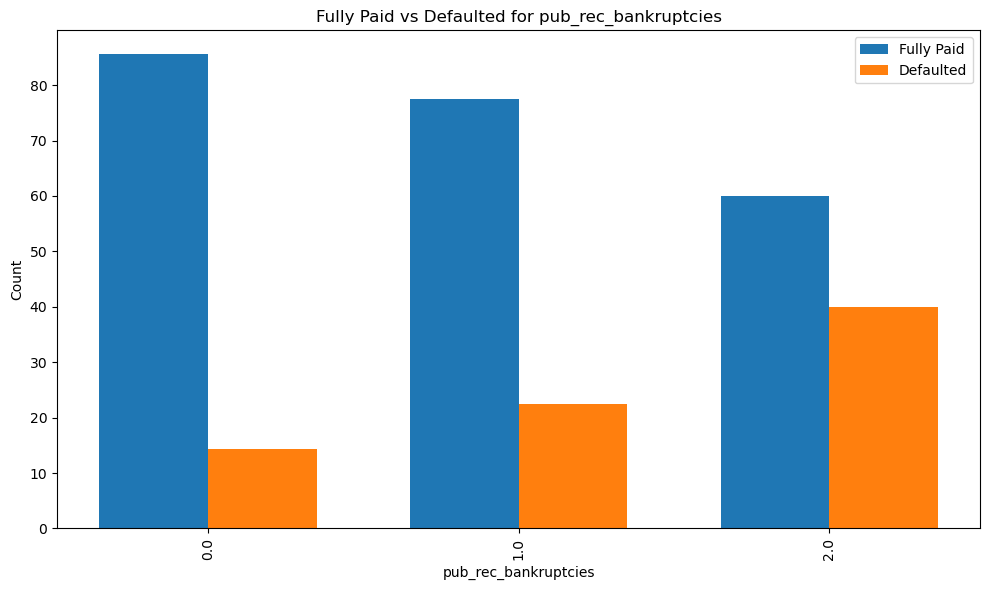

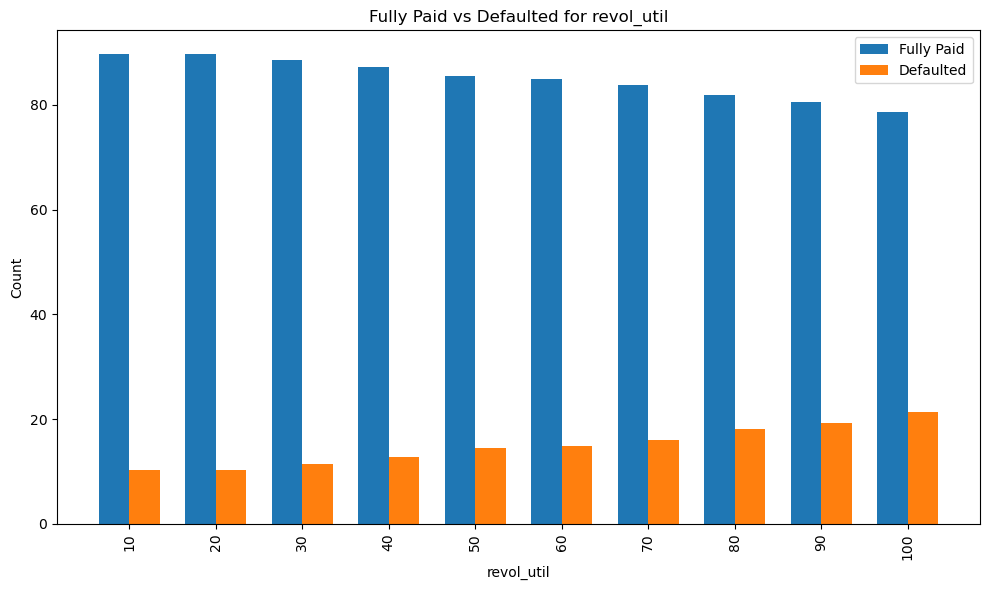

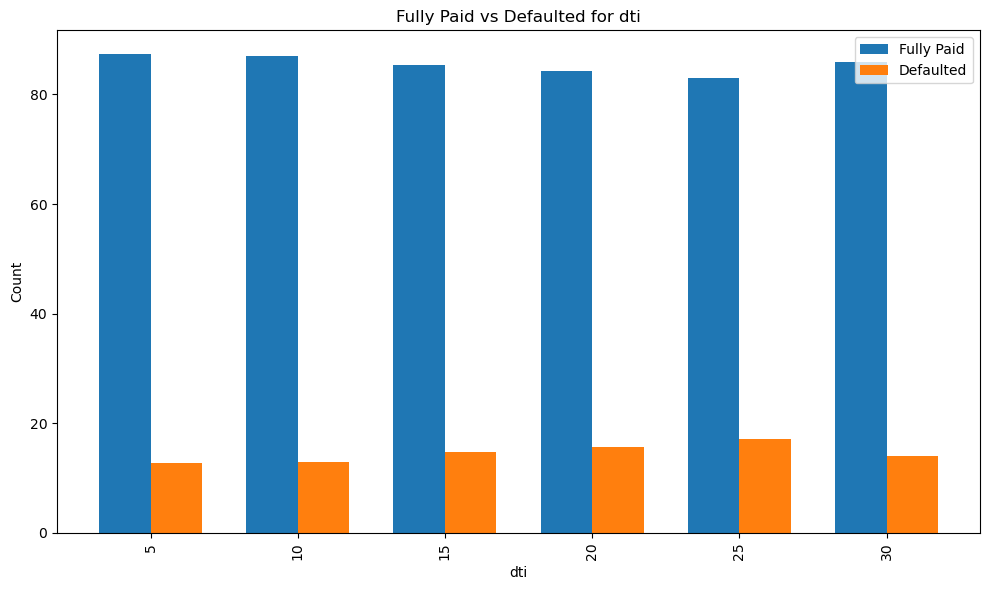

In [111]:
cat_cols = ['purpose', 'term', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'pub_rec', 'pub_rec_bankruptcies', 'revol_util', 'dti']
# cat_cols = ['emp_length']

for col in cat_cols:
    col_elems = natsorted(df[col].unique())
    if col == 'emp_length':
        col_elems.pop(0) # Removing NaN value
    defaulted_list = []
    fully_paid_list = []
    for col_elem in col_elems:
        subset_col_elem = df[df[col] == col_elem]
        total_borrowers = len(subset_col_elem)
        defaulted_col_elem = len(subset_col_elem[subset_col_elem['loan_status'] == 'Charged Off'])
        defaulted = (defaulted_col_elem / total_borrowers) * 100
        fully_paid_col_elem = len(subset_col_elem[subset_col_elem['loan_status'] == 'Fully Paid'])
        fully_paid = (fully_paid_col_elem / total_borrowers) * 100
        defaulted_list.append(defaulted)
        fully_paid_list.append(fully_paid)
        # print(f"Borrowers under {col_elem} who defaulted: {percentage_defaulted:.2f}%")


    x_indices = np.arange(len(col_elems))

    # Plotting
    width = 0.35  # width of the bars
    plt.figure(figsize=(10, 6))
    plt.bar(x_indices - width/2, fully_paid_list, width, label='Fully Paid')
    plt.bar(x_indices + width/2, defaulted_list, width, label='Defaulted')

    # Adding labels and title
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Fully Paid vs Defaulted for {col}')
    plt.xticks(x_indices, col_elems)
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

**Insights**
> 1. We can observe that Attributes like 'Employment Term in current company', 'Borrower Verification Status', 'Home Ownership', 'Number of derogatory public records', 'Borrowers monthly debt ratio' don't show any significant pattern and we can conclude that they do not impact the borrower directly on his/her loan repayment journey.
> 2. **Though Purpose for loan doesn't show any pattern, but it is keen to observe that borrowers taking loan for 'small_business' are more prone to defaulting.**
> 3. **For Loan term of 60 months the defaulters count is significantly higher than that of 36 months, which gives a clear sign that an increase in the Loan Repayment term can very likely end up in a Default scenario.**
> 4. **For SubGrade, as we go from - A1 to A5 up until G5, the rate of defaulting increases significantly. This pattern is most significant and we can wisely conclude that lower SuGrade (A > B > C > D > E > F > G) have higher possibility of Defaulting.**
> 5. **Bankruptcy records show a significant pattern as it shows that the chances of Defaulting increases with increasing past bankruptcy records.**
> 6. **Revolving Utilization Credit also shows significant pattern. The plot says that higher the Borrower's Utilization rate, increases the chance of Defaulting.**

## 5. Multivariate Analysis

Encoding the 'obect' type categorical variables

In [115]:
label_encoder = LabelEncoder()

for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column])


Plotting the Correlation Matrix

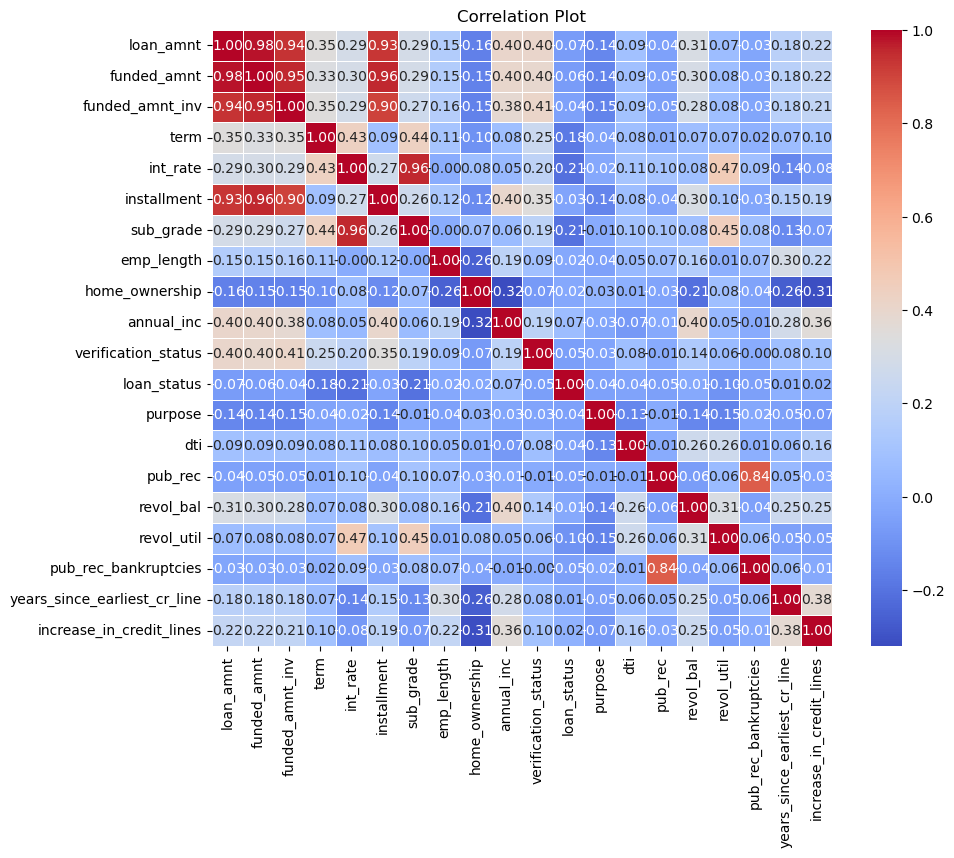

In [114]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Plot')
plt.show()

**Insights**

> Nothing significant was observed from the Correlation Matrix.

**END**